# Car Classification

**Цель** - подготовить и обучить нейросеть для распознавания марок автомобилей на картинках

**Задачи:**
 - разобрать baseline-проект
 - изучить различные практики и подходы улучшения качества нейросетей, такие как transfer learning с fine-tuning, использование callback Keras, ТТА и др.
 - применить изученные подходы к текущему проекту
 - попрактиковаться в решении задач компьтерного зрения на практике
 - добавить в портфолио еще один проект

**Основная идея данного проекта** - взять предобученую на сеть, например Xception или EfficientNet, и дообучить под нашу задачу. 

# 1. Import

In [1]:
# Проверим, что подключена видеокарта
!nvidia-smi

Sat Nov 13 16:47:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Установим недостающие пакеты

In [2]:
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

In [3]:
# Установим пакет с обученными сетями EfficientNetB3, EfficientNetB5, EfficientNetB6...
!pip install -q efficientnet

## Импортируем все необходимые пакеты

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import itertools

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler,EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from sklearn.model_selection import train_test_split, StratifiedKFold

from ImageDataAugmentor.image_data_augmentor import *
import albumentations as alb_aug

import efficientnet.tfkeras as efn

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.10 | packaged by conda-forge | (default, Sep 13 2021, 19:43:44) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0
Keras        : 2.6.0


**Работаем с Tensorflow v2.6**

## Для воспроизводимости сохраним версии всех пакетов

In [5]:
!pip freeze > requirements.txt

# 2. Setup

In [6]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8    # эпох на обучение
BATCH_SIZE           = 16    # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10   # количество классов в нашей задаче
IMG_SIZE             = (165, 220)  # какого размера подаем изображения в сеть
# IMG_SIZE             = (384, 512) 
IMG_CHANNELS         = 3    # у RGB 3 канала
input_shape          = (*IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

#MODEL = "efficient-b3"
#MODEL = 'Xception'
MODEL = 'EfficientNetB5'
#MODEL = 'EfficientNetB6'

In [7]:
# Словарь для сохранения точности модели на разных шагах
accuracy_dict = dict()

# Проверяем наличие директории
os.makedirs(PATH,exist_ok=False)

# Устаналиваем конкретное значение random seed для воспроизводимости
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# 3. Data

In [8]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [11]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


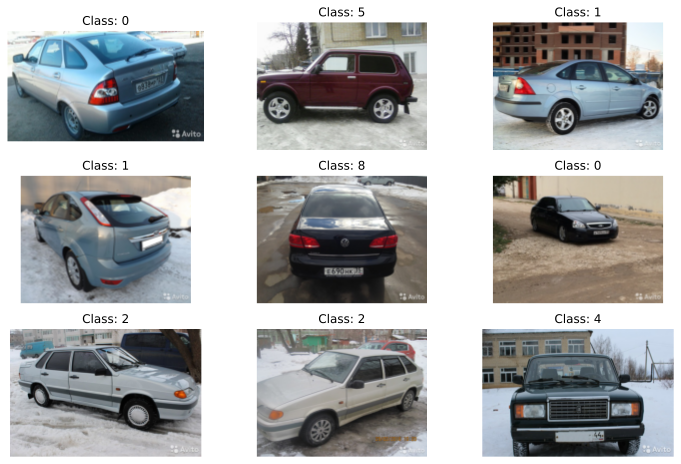

In [12]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

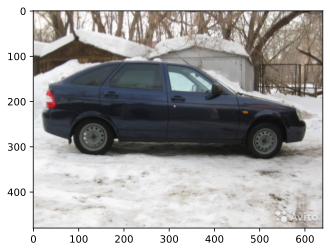

(640, 480)

In [13]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# 4. Cleaning and Prepping Data

## Определим вспомогательные функции

In [14]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
    generator = itertools.islice(generator, count)
    fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
    for batch, ax in zip(generator, axes):
        if labels:
            img_batch, labels_batch = batch
            img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
        else:
            img_batch = batch
            img = img_batch[0]
        if not normalized:
            img = img.astype(np.uint8)
        ax.imshow(img)
        # метод imshow принимает одно из двух:
        # - изображение в формате uint8, яркость от 0 до 255
        # - изображение в формате float, яркость от 0 до 1
        if labels:
            ax.set_title(f'Class: {label}')
    plt.show()

In [15]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [16]:
def print_accuracy_dict(accuracy_dict):
    print(f'Fine-tuning {MODEL}')
    for accuracy_type, accuracy_value in accuracy_dict.items():
        print(f'{accuracy_type} accuracy {accuracy_value}')

## Аугментация данных

Посмотрим два варианта аугментации данных

### Аугментация встроенными методами

In [17]:
my_datagen_classic = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 50,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

Found 15561 images belonging to 10 classes.


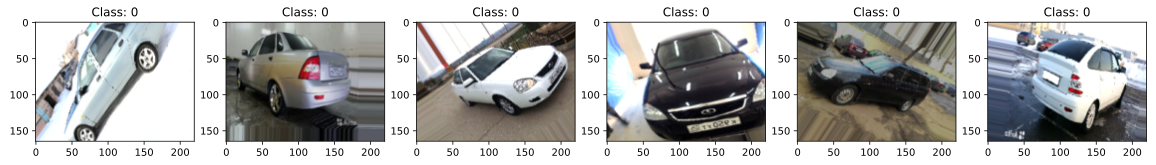

Found 15561 images belonging to 10 classes.


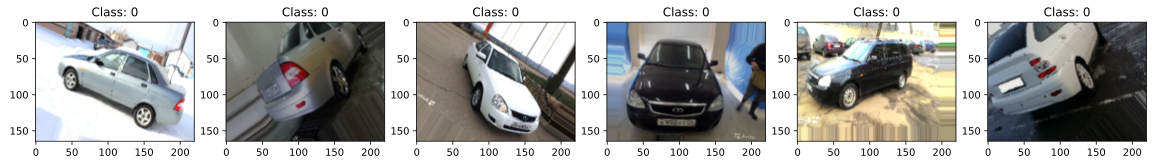

Found 15561 images belonging to 10 classes.


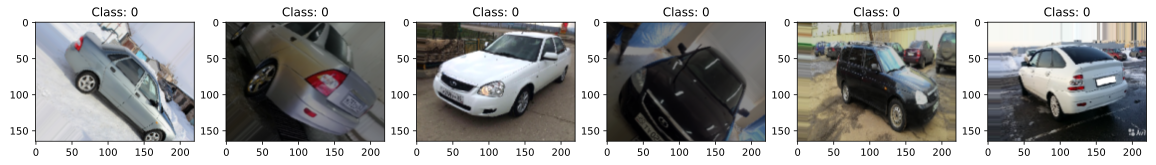

In [18]:
for _ in range(3):
    my_generator = my_datagen_classic.flow_from_directory(
        PATH+'train/',      # директория где расположены папки с картинками
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        # seed=RANDOM_SEED,
        subset='training'
    )
    show_first_images(my_generator, normalized=True)

### Аугментация с помощью библиотеки albumentations

In [19]:
AUGMENTATIONS = alb_aug.Compose([
    alb_aug.HorizontalFlip(p=0.5),
    alb_aug.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.01, 
        interpolation=1, 
        border_mode=4, 
        rotate_limit=20, 
        p=.75
    ),
    alb_aug.OneOf([
        alb_aug.CenterCrop(height=150, width=120),
        alb_aug.CenterCrop(height=150, width=220),
    ],p=0.5),
    alb_aug.OneOf([
        alb_aug.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        alb_aug.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    alb_aug.Cutout(p=0.5, num_holes=1, max_h_size=30, max_w_size=50), #первый раз
    alb_aug.Cutout(p=0.5, num_holes=1, max_h_size=40, max_w_size=70),  #второй раз
    alb_aug.GaussianBlur(p=0.05),
    alb_aug.RandomBrightness(limit=0.2, p=0.5),
    alb_aug.HueSaturationValue(p=0.5),
    alb_aug.RGBShift(p=0.5),
    alb_aug.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    alb_aug.Resize(*IMG_SIZE)
])

def print_aug_image(image):
    image = image.astype(np.uint8)
    return AUGMENTATIONS(image=image)['image']

my_datagen_albu = ImageDataGenerator(
    preprocessing_function=print_aug_image
)

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


Found 15561 images belonging to 10 classes.


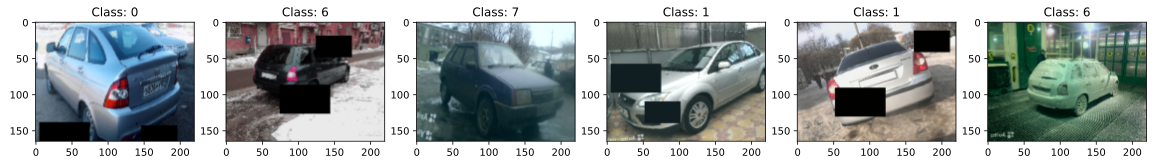

Found 15561 images belonging to 10 classes.


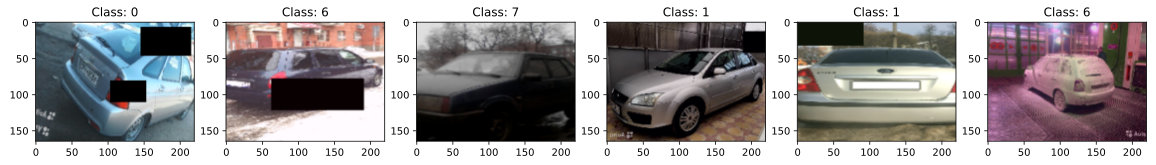

Found 15561 images belonging to 10 classes.


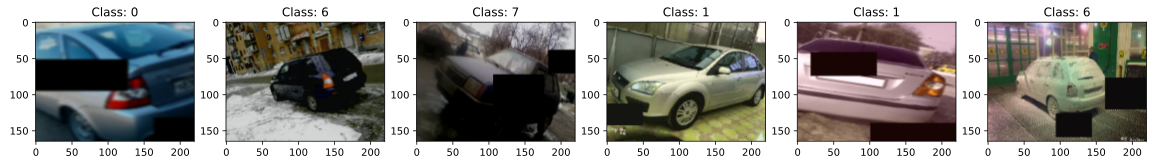

In [20]:
for _ in range(3):
    my_generator = my_datagen_albu.flow_from_directory(
        PATH+'train/',      # директория где расположены папки с картинками
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=RANDOM_SEED,
        subset='training'
    )
    show_first_images(my_generator)

**Итого:** Аугментация с помощью библиотеки Albumentations получается шире. Для нашей задачи возьмем именно такой способ.

## Генерация данных

Произведем аугментацию и завернем наши данные в генераторы

In [21]:
# Произведем аугментацию данных
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

valid_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training'
) # set as training data

test_valid_generator = valid_datagen.flow_from_directory(
    PATH+'train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
) # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Посмотрим на полившиеся данные генераторов

Train:


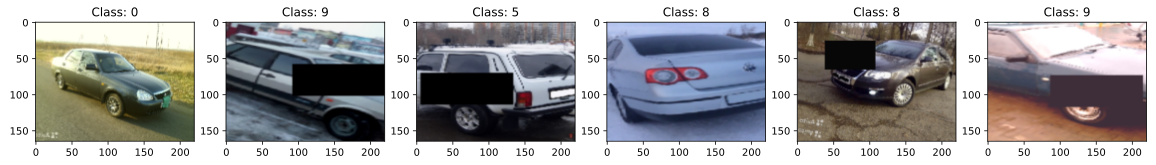

Val:


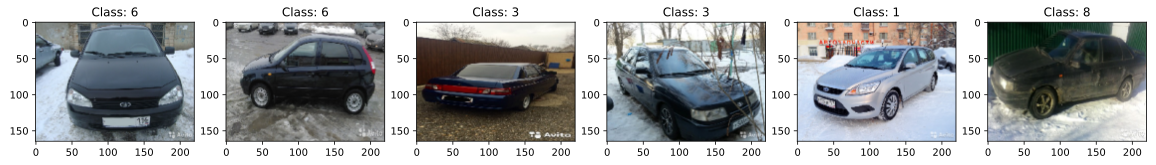

Sub:


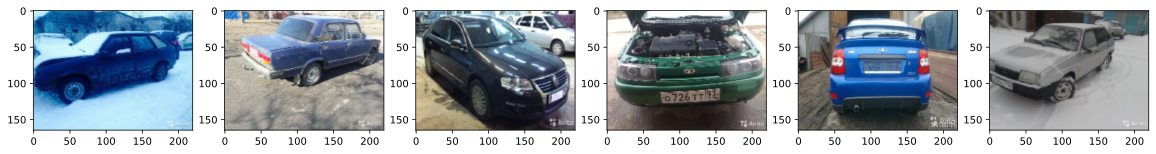

In [22]:
print('Train:')
show_first_images(train_generator, labels=True, normalized=True)

print('Val:')
show_first_images(test_valid_generator, labels=True, normalized=True)

print('Sub:')
show_first_images(test_sub_generator, labels=False, normalized=True)

# 4. Model

## Базовая модель

Загружаем предобученную сеть

In [23]:
# base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

# base_model = efn.EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)

# base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

2021-11-13 16:49:13.329821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 16:49:13.417864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 16:49:13.418634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 16:49:13.419936: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

115523584/115515256 [==============================] - 1s 0us/step


In [24]:
base_model.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 165, 220, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 83, 110, 48)  1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 83, 110, 48)  192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 83, 110, 48)  0           stem_bn[0][0]                    
____________________________________________________________________________________

## "Голова" Модели

In [25]:
# Устанавливаем новую "голову" (head)
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 
model.add(L.Dense(256, activation='relu', bias_regularizer=l2(1e-4), activity_regularizer=l2(1e-5)))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 6, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 29,041,658
Trainable params: 28,868,410
Non-trainable params: 173,248
______________________________________

## Обучение модели

### Коллбэки

Определим коллбэки для нашей будущей модели. В частности добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [27]:
callback_early_stopping = EarlyStopping(monitor='accuracy', patience=5, verbose=1)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-6, patience=2, verbose=1)

callback_checkpoint = ModelCheckpoint(f'{MODEL}_best.hdf5', monitor=['val_acc'], verbose=1, mode ='max') 

# callback_learing_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x),    
# path_checkpoint = 'checkpoint.keras'
# ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,save_weights_only=True, save_best_only=True)

callbacks = [callback_checkpoint, callback_reduce_lr, callback_early_stopping]

### Step 1. Обучаем только голову модели

Для начала заморозим веса базовой и обучим только "голову". Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения

In [28]:
# Для начала заморозим веса базовой и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

# сколько слоев
print(len(model.layers))
len(model.trainable_variables)
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

6
<keras.engine.functional.Functional object at 0x7f3e23d93450> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3e234813d0> True
<keras.layers.core.Dense object at 0x7f3e38b9ec50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3e38ba2250> True
<keras.layers.core.Dropout object at 0x7f3e38e4d490> True
<keras.layers.core.Dense object at 0x7f3e38e4dd90> True


In [29]:
model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

In [30]:
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

2021-11-13 16:49:26.529153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8


2021-11-13 16:49:38.874156: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


827/827 [==============================] - 159s 171ms/step - loss: 1.9463 - accuracy: 0.3374 - val_loss: 1.2409 - val_accuracy: 0.5573

Epoch 00001: saving model to EfficientNetB5_best.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/8
827/827 [==============================] - 142s 172ms/step - loss: 1.6434 - accuracy: 0.4190 - val_loss: 1.1538 - val_accuracy: 0.5977

Epoch 00002: saving model to EfficientNetB5_best.hdf5
Epoch 3/8
827/827 [==============================] - 140s 169ms/step - loss: 1.5700 - accuracy: 0.4398 - val_loss: 1.0940 - val_accuracy: 0.6226

Epoch 00003: saving model to EfficientNetB5_best.hdf5
Epoch 4/8
827/827 [==============================] - 142s 171ms/step - loss: 1.5409 - accuracy: 0.4484 - val_loss: 1.0415 - val_accuracy: 0.6509

Epoch 00004: saving model to EfficientNetB5_best.hdf5
Epoch 5/8
827/827 [==============================] - 142s 172ms/step - loss: 1.5083 - accuracy: 0.4671 - val_loss: 1.0508 - val_accuracy: 0.6213

Epoch 00005: saving model to EfficientNetB5_best.hdf5
Epoch 6/8
827/827 [==============================] - 142s 172ms/step - loss: 1.5054 - accuracy: 0.4633 - val_loss: 1.0018 - val_accuracy: 0.6475

Epoch 00006: saving model to EfficientNetB5_best.hdf5


In [31]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении 
model.save(f'{MODEL}_last.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

In [32]:
scores = model.evaluate(test_valid_generator, steps=len(test_valid_generator), verbose=1)

# Словарь для сохранения точности модели на разных шагах
accuracy_dict = dict()
accuracy_dict['0% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

146/146 [==============================] - 14s 98ms/step - loss: 0.9649 - accuracy: 0.6638
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 66.38%


Посмотрим графики обучения:

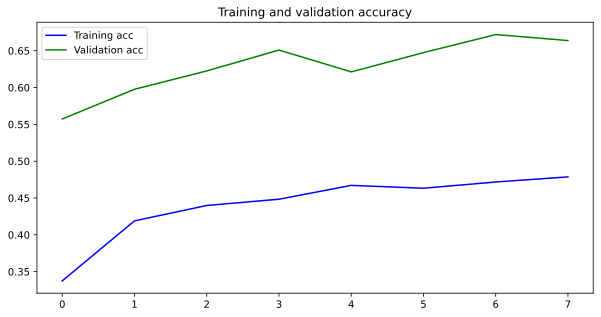

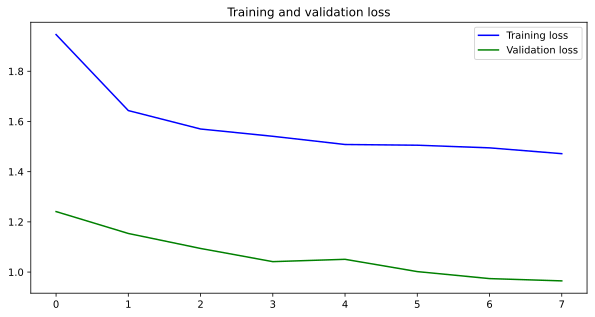

In [33]:
plot_history(history)

### Step 2. Размораживаем веса в половине слоев базовой модели

In [34]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

print("Number of layers in the base model: ", len(base_model.layers))    
print('Number of defrosted layers in the base model: ', len(base_model.trainable_variables))

<keras.engine.functional.Functional object at 0x7f3e23d93450> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3e234813d0> True
<keras.layers.core.Dense object at 0x7f3e38b9ec50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3e38ba2250> True
<keras.layers.core.Dropout object at 0x7f3e38e4d490> True
<keras.layers.core.Dense object at 0x7f3e38e4dd90> True
Number of layers in the base model:  569
Number of defrosted layers in the base model:  252


In [35]:
EPOCHS = 15    # увеличим число эпох на обучение
LR     = 1e-3  # уменьшаем learning_rate

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

In [36]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

Epoch 1/15
827/827 [==============================] - 194s 215ms/step - loss: 1.2837 - accuracy: 0.5622 - val_loss: 0.7023 - val_accuracy: 0.7746

Epoch 00001: saving model to EfficientNetB5_best.hdf5
Epoch 2/15
827/827 [==============================] - 173s 209ms/step - loss: 0.8059 - accuracy: 0.7227 - val_loss: 0.4006 - val_accuracy: 0.8776

Epoch 00002: saving model to EfficientNetB5_best.hdf5
Epoch 3/15
827/827 [==============================] - 176s 213ms/step - loss: 0.6848 - accuracy: 0.7698 - val_loss: 0.3655 - val_accuracy: 0.8811

Epoch 00003: saving model to EfficientNetB5_best.hdf5
Epoch 4/15
827/827 [==============================] - 174s 211ms/step - loss: 0.6109 - accuracy: 0.7959 - val_loss: 0.3274 - val_accuracy: 0.8974

Epoch 00004: saving model to EfficientNetB5_best.hdf5
Epoch 5/15
827/827 [==============================] - 168s 203ms/step - loss: 0.5484 - accuracy: 0.8153 - val_loss: 0.3021 - val_accuracy: 0.9073

Epoch 00005: saving model to EfficientNetB5_best.

In [37]:
model.save(f'{MODEL}_last_finetuning.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

In [38]:
scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['50% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


146/146 [==============================] - 14s 93ms/step - loss: 0.1837 - accuracy: 0.9442
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 66.38%
50% weights defrosting accuracy 94.42%


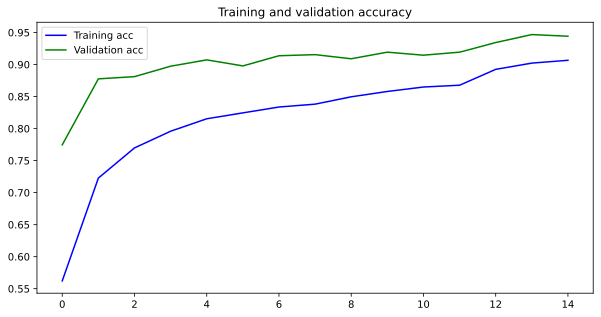

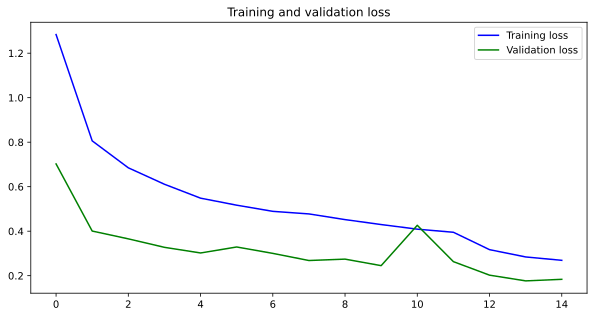

In [39]:
plot_history(history)

### Step 3. Размораживаем веса в 75% слоев базовой модели

In [40]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//4

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

print("Number of layers in the base model: ", len(base_model.layers))    
print('Number of defrosted layers in the base model: ', len(base_model.trainable_variables))

<keras.engine.functional.Functional object at 0x7f3e23d93450> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3e234813d0> True
<keras.layers.core.Dense object at 0x7f3e38b9ec50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3e38ba2250> True
<keras.layers.core.Dropout object at 0x7f3e38e4d490> True
<keras.layers.core.Dense object at 0x7f3e38e4dd90> True
Number of layers in the base model:  569
Number of defrosted layers in the base model:  377


In [41]:
EPOCHS = 8    # уменьшим число эпох на обучение
LR     = 1e-4  # уменьшаем learning_rate

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

In [42]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

Epoch 1/8
827/827 [==============================] - 209s 231ms/step - loss: 0.2675 - accuracy: 0.9070 - val_loss: 0.1653 - val_accuracy: 0.9498

Epoch 00001: saving model to EfficientNetB5_best.hdf5
Epoch 2/8
827/827 [==============================] - 188s 228ms/step - loss: 0.2275 - accuracy: 0.9179 - val_loss: 0.1620 - val_accuracy: 0.9489

Epoch 00002: saving model to EfficientNetB5_best.hdf5
Epoch 3/8
827/827 [==============================] - 190s 229ms/step - loss: 0.2039 - accuracy: 0.9262 - val_loss: 0.1561 - val_accuracy: 0.9511

Epoch 00003: saving model to EfficientNetB5_best.hdf5
Epoch 4/8
827/827 [==============================] - 189s 229ms/step - loss: 0.1914 - accuracy: 0.9329 - val_loss: 0.1485 - val_accuracy: 0.9506

Epoch 00004: saving model to EfficientNetB5_best.hdf5
Epoch 5/8
827/827 [==============================] - 184s 223ms/step - loss: 0.1853 - accuracy: 0.9342 - val_loss: 0.1595 - val_accuracy: 0.9502

Epoch 00005: saving model to EfficientNetB5_best.hdf5


In [43]:
model.save(f'{MODEL}_last_finetuning.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

In [44]:
scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['75% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

146/146 [==============================] - 14s 94ms/step - loss: 0.1497 - accuracy: 0.9523
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 66.38%
50% weights defrosting accuracy 94.42%
75% weights defrosting accuracy 95.23%


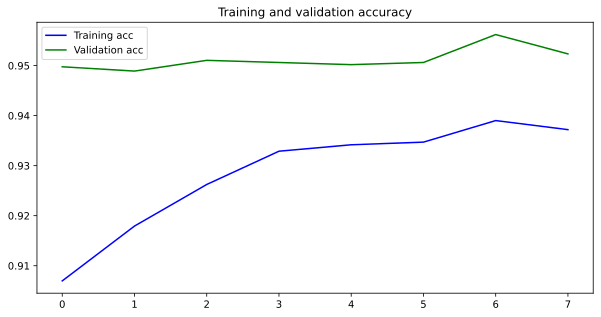

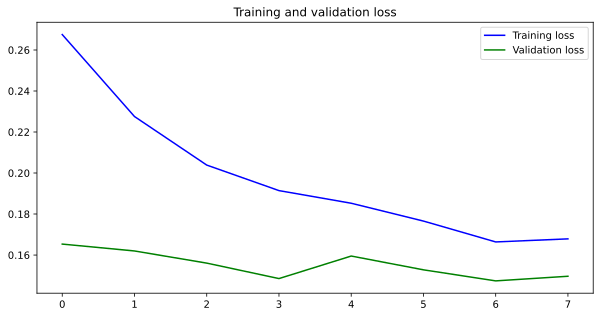

In [45]:
plot_history(history)

### Step 4. Размораживаем веса во всех слоях базовой модели и увеличим разрешение изображений

Разморозим веса в модели:

In [46]:
base_model.trainable = True

# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

print("Number of layers in the base model: ", len(base_model.layers))    
print('Number of defrosted layers in the base model: ', len(base_model.trainable_variables))

<keras.engine.functional.Functional object at 0x7f3e23d93450> True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f3e234813d0> True
<keras.layers.core.Dense object at 0x7f3e38b9ec50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f3e38ba2250> True
<keras.layers.core.Dropout object at 0x7f3e38e4d490> True
<keras.layers.core.Dense object at 0x7f3e38e4dd90> True
Number of layers in the base model:  569
Number of defrosted layers in the base model:  504


Поменяем параметры модели, в частности увеличим разрешение изображений и подберем количество эпох и батч, чтобы не перегрузить видеокарту

In [47]:
EPOCHS = 4    # увеличим число эпох на обучение
LR     = 1e-5  # уменьшаем learning_rate
BATCH_SIZE = 4
IMG_SIZE   = (384, 512)

model.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.Adam(learning_rate=LR), 
    metrics=["accuracy"]
)

Упростим аугментацию изображений

In [48]:
AUGMENTATIONS = alb_aug.Compose([
    alb_aug.HorizontalFlip(p=0.5),
    alb_aug.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.01, 
        interpolation=1, 
        border_mode=4, 
        rotate_limit=20, 
        p=.75
    ),
    alb_aug.RandomBrightness(limit=0.2, p=0.5),
    alb_aug.Resize(*IMG_SIZE)
])

# Произведем аугментацию данных
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

valid_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

In [49]:
# Завернем наши данные в генератор:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training'
) # set as training data

test_valid_generator = valid_datagen.flow_from_directory(
    PATH+'train/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
) # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [50]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_valid_generator, 
        validation_steps = len(test_valid_generator),
        epochs = EPOCHS,
        callbacks = callbacks
)

Epoch 1/4
3308/3308 [==============================] - 1429s 426ms/step - loss: 0.6088 - accuracy: 0.8112 - val_loss: 0.3447 - val_accuracy: 0.9322

Epoch 00001: saving model to EfficientNetB5_best.hdf5
Epoch 2/4
3308/3308 [==============================] - 1449s 438ms/step - loss: 0.3650 - accuracy: 0.8879 - val_loss: 0.5568 - val_accuracy: 0.9446

Epoch 00002: saving model to EfficientNetB5_best.hdf5
Epoch 3/4
3308/3308 [==============================] - 1410s 426ms/step - loss: 0.3066 - accuracy: 0.9072 - val_loss: 0.5005 - val_accuracy: 0.9562

Epoch 00003: saving model to EfficientNetB5_best.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
Epoch 4/4
3308/3308 [==============================] - 1411s 426ms/step - loss: 0.2589 - accuracy: 0.9225 - val_loss: 0.5118 - val_accuracy: 0.9601

Epoch 00004: saving model to EfficientNetB5_best.hdf5


In [51]:
model.save(f'{MODEL}_last_finetuning.hdf5')
model.load_weights(f'{MODEL}_best.hdf5')

In [52]:
scores = model.evaluate_generator(test_valid_generator, verbose=1)
accuracy_dict['100% weights defrosting'] = "%.2f%%" % (scores[1]*100)

# Напечатаем значения accuracy на различных steps
print_accuracy_dict(accuracy_dict)

583/583 [==============================] - 44s 76ms/step - loss: 0.5118 - accuracy: 0.9601
Fine-tuning EfficientNetB5
0% weights defrosting accuracy 66.38%
50% weights defrosting accuracy 94.42%
75% weights defrosting accuracy 95.23%
100% weights defrosting accuracy 96.01%


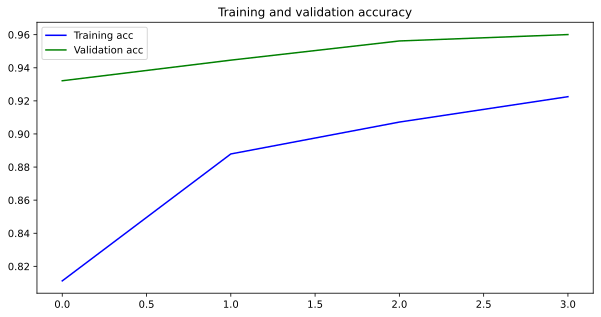

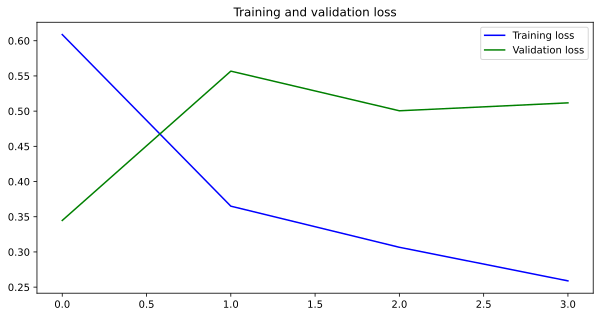

In [53]:
plot_history(history)

# Submission

In [54]:
test_sub_generator.samples

6675

In [55]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1669/1669 [==============================] - 110s 64ms/step


In [56]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [57]:
submission.head()

Id Category
0  305108.jpg        7
1  295075.jpg        6
2   31197.jpg        4
3   93598.jpg        7
4   87877.jpg        7

# Test Time Augmentation

**Test-time augmentations (TTA)** - применение аугментаций к изображениям при инференсе для улучшения качества предсказаний. Для каждого изображения мы получаем несколько предсказаний и усредняем их.

In [58]:
model.load_weights(f'{MODEL}_best.hdf5')

Упростим Аугментацию изображений

In [59]:
AUGMENTATIONS = alb_aug.Compose([
    alb_aug.HorizontalFlip(p=0.5),
    alb_aug.ShiftScaleRotate(
        shift_limit=0.0625, 
        scale_limit=0.01, 
        interpolation=1, 
        border_mode=4, 
        rotate_limit=20, 
        p=.75
    ),
    alb_aug.RandomBrightness(limit=0.2, p=0.5),
    alb_aug.Resize(*IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [60]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'/test_upload',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [61]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1669/1669 [==============================] - 110s 66ms/step


In [62]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [63]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame(
    {'Id':filenames_with_dir, 'Category':predictions}, 
    columns=['Id', 'Category']
)
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


In [64]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

# Эффективность моделей

1. Fine-tuning model **Xception** with image size (384, 512) and batch size 8 
 - 0%   weights defrosting, 6  epochs, 1e-3 learning rate - accuracy 66.55%
 - 50%  weights defrosting, 12 epochs, 1e-3 learning rate - accuracy 95.58%
 - 75%  weights defrosting, 12 epochs, 1e-4 learning rate - accuracy 97.04%
 - 100% weights defrosting, 8  epochs, 1e-5 learning rate - accuracy 97.08%
 - Submit accuracy **96.93%**
 - Submit TTA accuracy 96.57%
 
 
2. Fine-tuning model **EfficientNetB6** with image size (384, 512) and batch size 8 
 - 0%   weights defrosting, 6  epochs, 1e-3 learning rate - accuracy 75.35%
 - 50%  weights defrosting, 12 epochs, 1e-3 learning rate - accuracy 94.46%
 - 75%  weights defrosting, 12 epochs, 1e-4 learning rate - accuracy 96.61%
 - 100% weights defrosting, 6  epochs, 1e-5 learning rate, 4 batch size - accuracy 69.99%
 - Submit accuracy **96.78%**
 - Submit TTA accuracy 96.43%
 
3. Fine-tuning **EfficientNetB5** with image size (165, 220) and batch size 16
 - 0%   weights defrosting, 8  epochs, 1e-3 learning rate - accuracy 67.28%
 - 50%  weights defrosting, 15 epochs, 1e-3 learning rate - accuracy 94.80%
 - 75%  weights defrosting, 12 epochs, 1e-4 learning rate - accuracy 95.49%
 - 100% weights defrosting, 10 epochs, 1e-5 learning rate, rise image size (384, 512) and batch size 4 - accuracy 97.17%
 - Submit accuracy **97.24%**
 - Submit TTA accuracy 97.22%

# Итого

За основу был взят baseline-проект. Для улучшения результата в проекте были использованы слудующие практики:

 - Применен transfer learning и fine-tuning. Сначала обучение головы, потом 50% разморозка весов предобученной модели, после 75% разморозка весов и в завершение 100% разморозка.
 - Настройка LR на каждом шаге fine-tuning и в callback.
 - Опробованы различные переменные - увеличение размера картинок, количество эпох и подбор батч
 - Использовались различные предобученные сети - Xception и EfficientNet.
 - Добавлена Batch Normalization в архитектуре “головы” модели 
 - Использованы дополнительные функции callback в Keras
 - Добавлена TTA (Test Time Augmentation)
 - Использована более продвинутая библиотека аугментации изображений albumentations
 

Ввиду ограничений на пользование ресурсами GPU и времязатратности самого просчета модели, большую часть вычислений производилось на платформе Google Colab. По этой же причине не удалось протестировать некоторые техники настройки модели, такие как:

 - Настройка optimizer
 - Настройка loss
 - Нспользование внешних датасетов для дообучения модели
 - Ансамблирование различных моделей